In [2]:
import torch
from conex import Fire
from conex.behaviors.network.time_resolution import TimeResolution
from pymonntorch import EventRecorder, Recorder, Network
import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.currents import SetCurrent, ConstantCurrent, CurrentSum
from models.dendrites import Dendrite
from models.encoders import FeedDataset, Poisson, CustomPoisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar, SimpleSTDP
from models.neurons import LIF
from models.synapses import FullyConnectedSynapse
# from models.time_res import TimeResolution
from simulate import Simulation
from utils.dataset import load_data, read_and_flatten_image, add_overlap

In [3]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)

In [4]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
# Create an instance of Poisson
encoder = Poisson(time_window=50, ratio=0.5)
# encoder = PoissonEncoder(duration=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])
input_layer = sim.add_neuron_group(
    tag="inp_layer",
    size=9,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            v_rest=-65,
            v_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        # 7:Fire(),
        8: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="inp_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="inp_layer_event")
    }
)


sim.simulate(iterations=50)

Network['Network_1', 'Network'](Neurons: tensor(9)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['inp_layer', 'CustomNeuronGroup', 'ng'](9){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)8:FeedDataset(encoded_dataset=tensor([[[False, False, False, False,  True, False, False, False, False],
         [ True, False, False,  True,  True, False,  True, False, False],
         [False, False, False,  True, False, False, False, False, False],
         [ True, False, False, False, False, False,  True, False, False],
         [False, False, False,  True,  True, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False,  True, False, False, False, False, False],
         [ True, False, False, False, False, False, False, False, False],
         [False, False, False,  True,  True, False, False, F

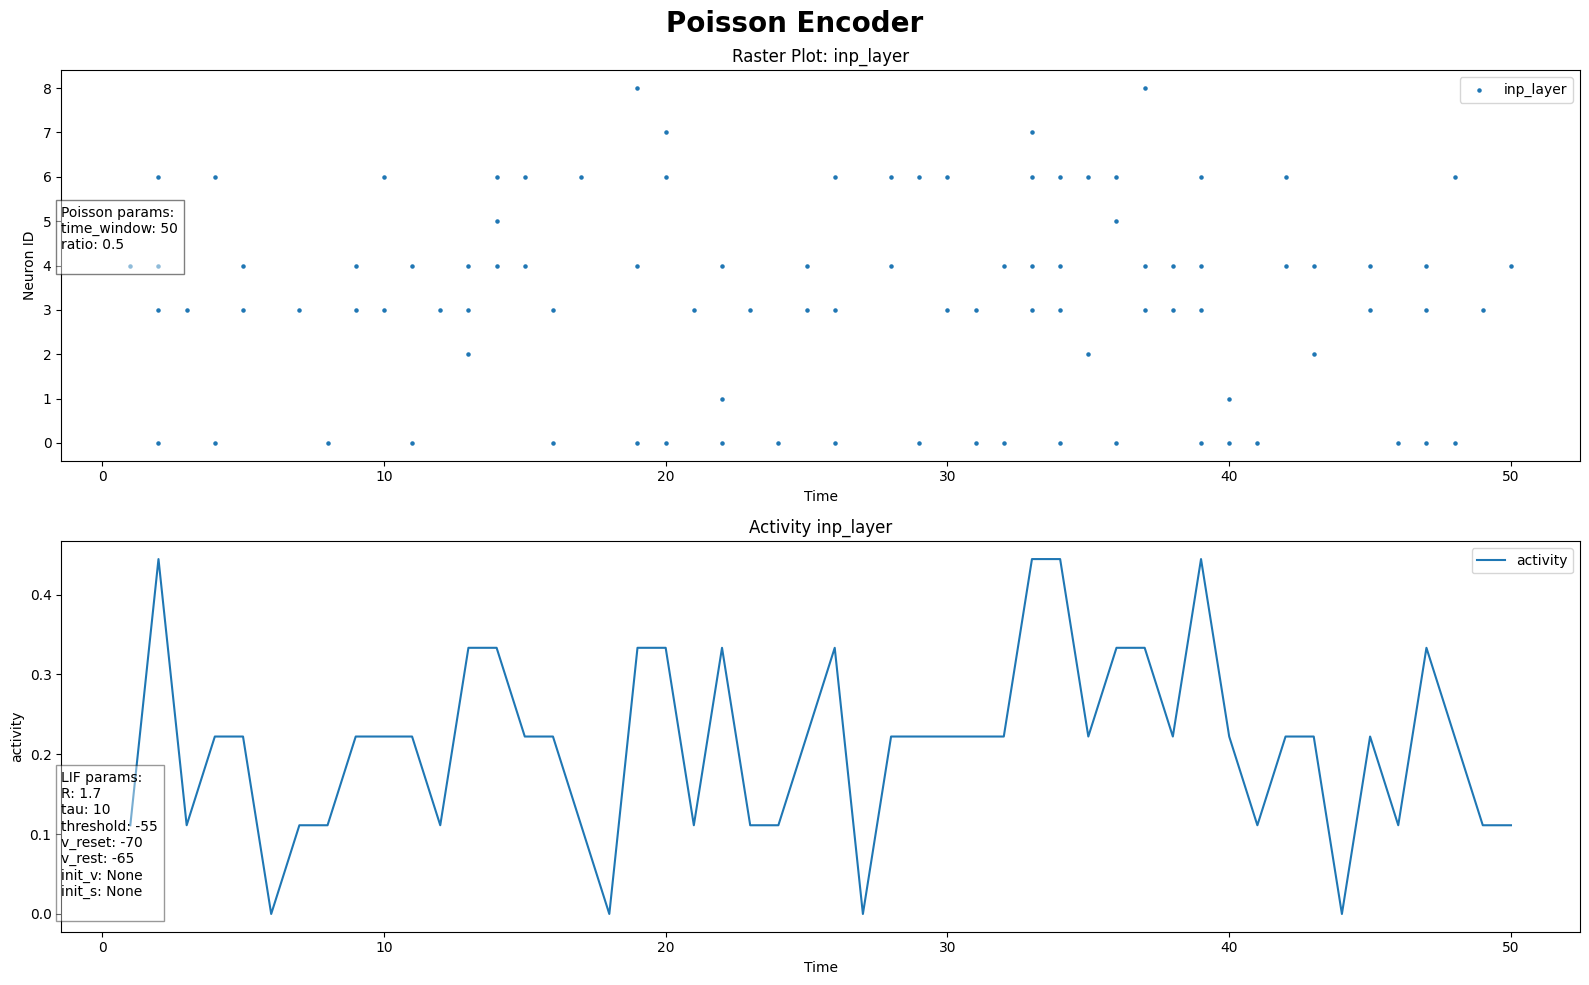

In [5]:
# fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)
fig = plt.figure(figsize=(16, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(2, 1, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1)
encoder.add_encoder_info(ax1, text_y=0.5)

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax2)
input_layer.add_neuron_model_params_info(ax2, model_idx=6)

fig.suptitle("Poisson Encoder", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/poisson-image-encoding.pdf")
plt.show()

# Simple STDP

In [6]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
# encoder = Poisson(time_window=50, ratio=0.5)
encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

input_layer = sim.add_neuron_group(
    tag="inp_layer",
    size=18,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        # 7:Fire(),
        8: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="inp_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="inp_layer_event")
    }
)

output_layer = sim.add_neuron_group(
    tag="output_layer",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        4: Dendrite(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="output_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="output_layer_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=input_layer,
                   dst=output_layer,
                   behavior={3: FullyConnectedSynapse(j0=40, variance=0.5),
                             # 8: RSTDP(tau_pre=4,
                             #        tau_post=3,
                             #        tau_c=50,
                             #        w_max=10,
                             #        w_min=-10,
                             #        learning_rate=0.001,
                             #        positive_dopamine=10,
                             #        negative_dopamine=-10),
                             8: SimpleSTDP(tau_pre=4,
                                           tau_post=3,
                                           a_plus=1.0,
                                           a_minus=1.0,
                                           w_max=10,
                                           w_min=-10,
                                           positive_bound="hard_bound",
                                           negative_bound="hard_bound"),
                             9: Recorder(variables=["weights"], tag="syn_inp_out_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['inp_layer', 'CustomNeuronGroup', 'ng'](18){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)8:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ..., False,  True, False],
         ...,
         [False, False, False,  ...,  True, False,  True],
         [False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


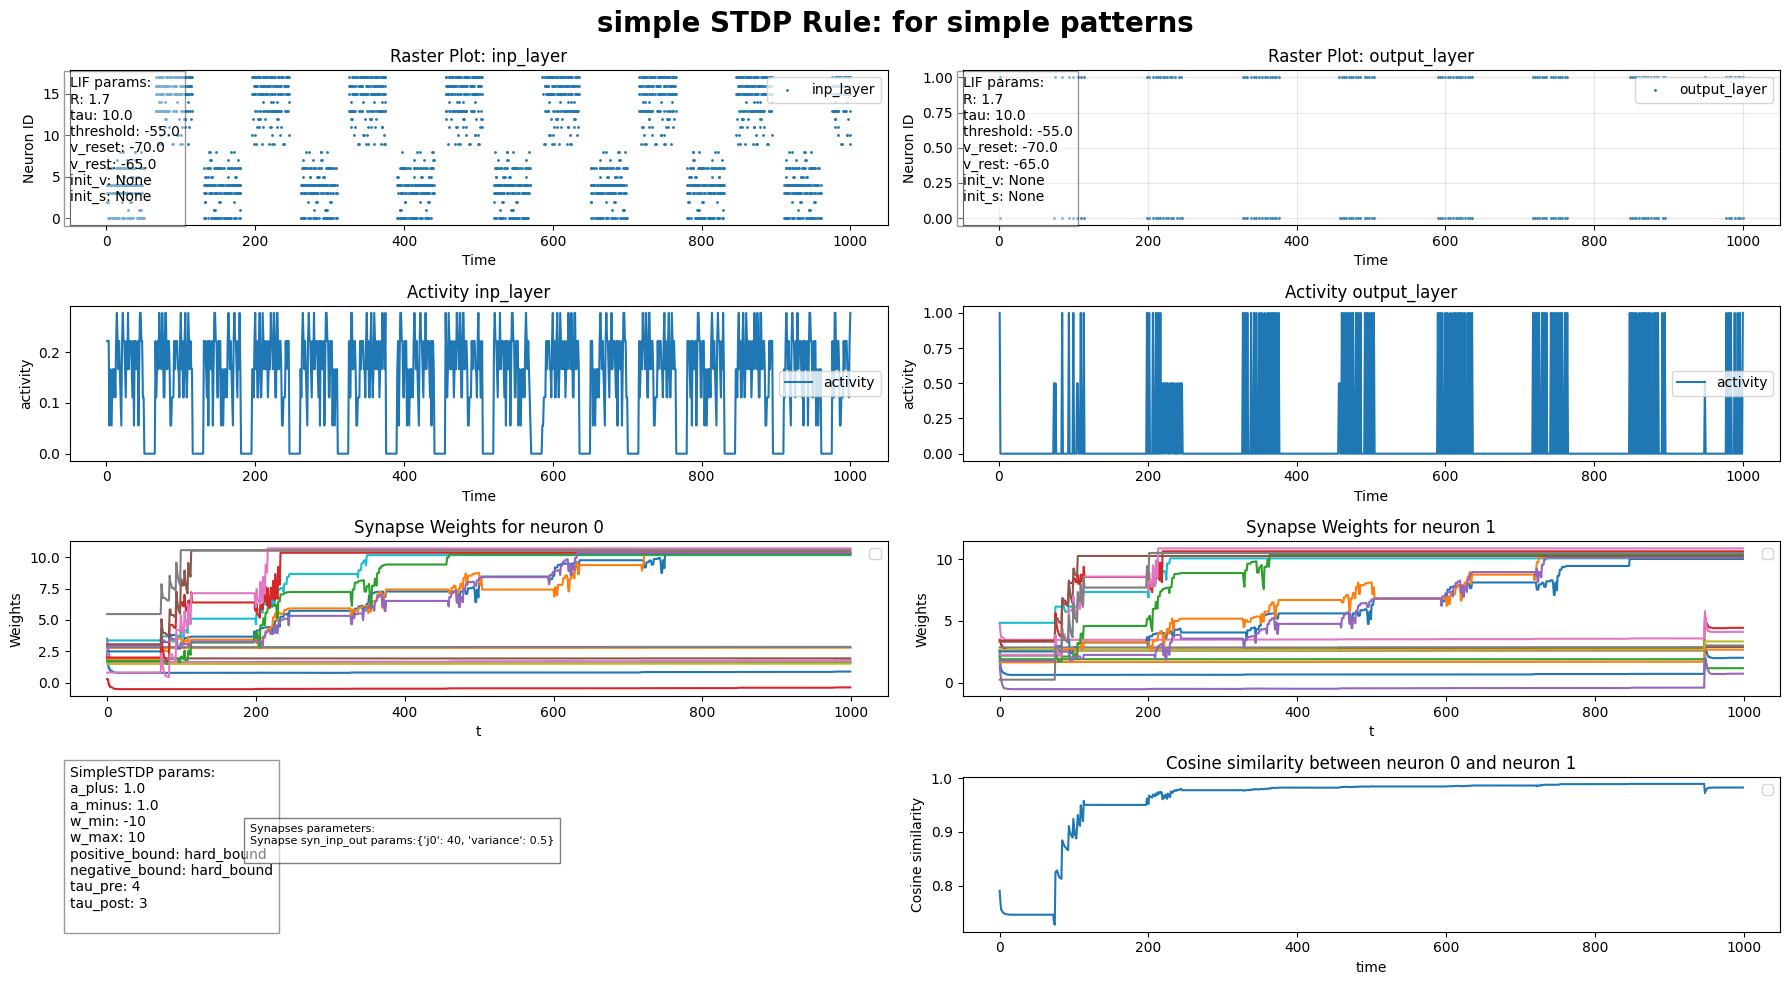

In [7]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, s=1)
input_layer.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, s=1)
output_layer.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("simple STDP Rule: for simple patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

# Paired base STDP: Local Variables

In [8]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
# encoder = Poisson(time_window=50, ratio=0.5)
encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

input_layer = sim.add_neuron_group(
    tag="inp_layer",
    size=18,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        # 7:Fire(),
        8: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="inp_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="inp_layer_event")
    }
)

output_layer = sim.add_neuron_group(
    tag="output_layer",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        4: Dendrite(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="output_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="output_layer_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=input_layer,
                   dst=output_layer,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.5),
                             # 8: RSTDP(tau_pre=4,
                             #        tau_post=3,
                             #        tau_c=50,
                             #        w_max=10,
                             #        w_min=-10,
                             #        learning_rate=0.001,
                             #        positive_dopamine=10,
                             #        negative_dopamine=-10),
                             8: PairedSTDPLocalVar(tau_pre=4,
                                                   tau_post=3,
                                                   w_max=10,
                                                   w_min=-10,
                                                   learning_rate=0.001),
                             9: Recorder(variables=["weights"], tag="syn_inp_out_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['inp_layer', 'CustomNeuronGroup', 'ng'](18){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)8:FeedDataset(encoded_dataset=tensor([[[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ...,  True, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True, False],
         [False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


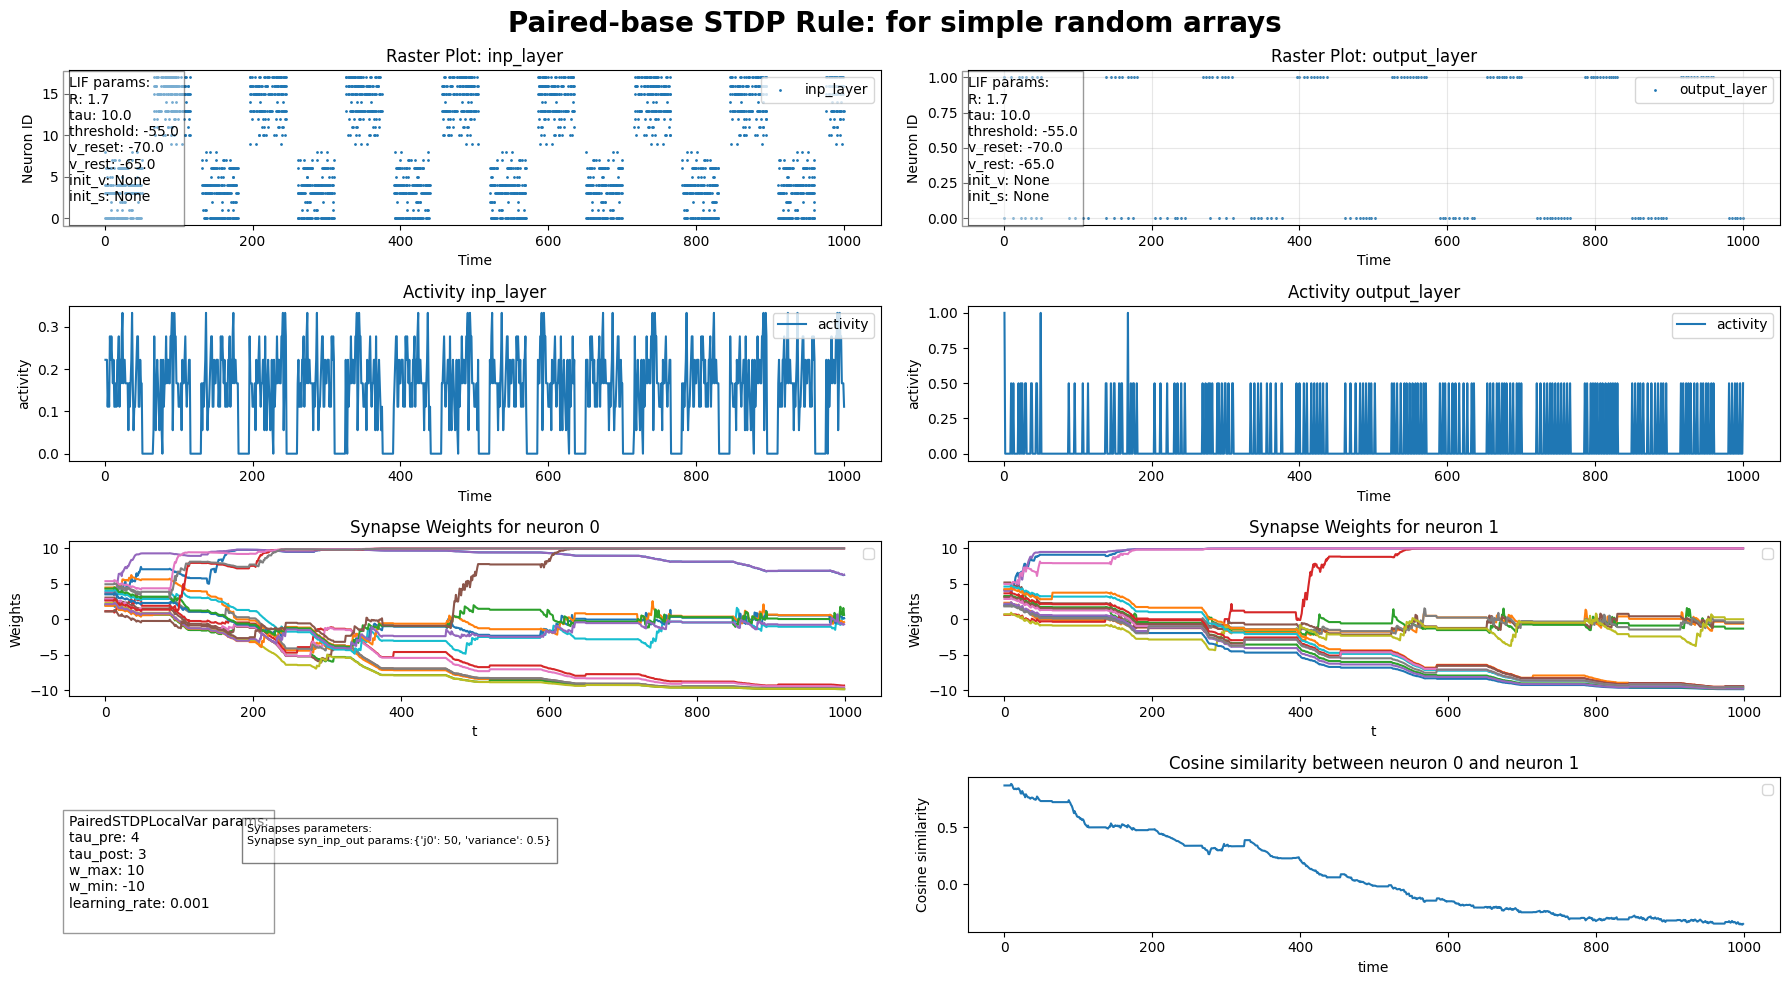

In [9]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, s=1)
input_layer.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, s=1)
output_layer.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

# Paired-base RSTDP

In [12]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
# encoder = Poisson(time_window=50, ratio=0.5)
encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

input_layer = sim.add_neuron_group(
    tag="inp_layer",
    size=18,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        # 7:Fire(),
        8: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="inp_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="inp_layer_event")
    }
)

output_layer = sim.add_neuron_group(
    tag="output_layer",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        4: Dendrite(),
        6: LIF(
            tau=10.0,
            v_rest=-65.0,
            v_reset=-70.0,
            threshold=-55.0,
            R=1.7,
        ),
        # 7:Fire(),
        9: ActivityRecorder(),
        10: Recorder(variables=["v", "I", "inp_I", "activity"], tag="output_layer_rec"),
        11: EventRecorder(variables=['spikes'], tag="output_layer_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=input_layer,
                   dst=output_layer,
                   behavior={3: FullyConnectedSynapse(j0=40, variance=0.5),
                             8: PairedRSTDPLocalVar(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             9: Recorder(variables=["weights"], tag="syn_inp_out_rec"),
                             },
)
sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['inp_layer', 'CustomNeuronGroup', 'ng'](18){6:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)8:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True, False,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False]],

        [[False, False, False,  ...,  True, False,  True],
         [False, False, False,  ...,  True, False, False],
         [False, False, False,  ..., False, False,  True],
         ...,
         [False, False, False,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, Fa

AttributeError: 'CustomNeuronGroup' object has no attribute 'I'

In [ ]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, s=1)
input_layer.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, s=1)
output_layer.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=8)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base RSTDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()